> The goal of the study project is to predict the price of an apartments (per square meter)   
in different areas of Israel.  
Source of Data [yad2](https://www.yad2.co.il/realestate/forsale).

## Imports and custom functions

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.float_format", "{:.2f}".format)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
# @title custom function predict_score
def predict_score(X_train, X_test, y_train, y_test, model):

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    rmse_train = mse(y_train, y_train_pred, squared=False)
    rmse_test = mse(y_test, y_test_pred, squared=False)
    r2_train = model.score(X_train, y_train)
    r2_test = model.score(X_test, y_test)

    print(f'R2_train = {r2_train:.3f} \tRMSE_train = {rmse_train:,.0f}')
    print(f'R2_test = {r2_test:^7.3f}  \tRMSE_test = {rmse_test:^7,.0f}')

In [ ]:
# @title custom function predict_error_residual_plot
def predict_error_residual_plot(estimator, X_train, y_train, X_test, y_test):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    p1 = prediction_error(estimator, X_train, y_train, X_test, y_test, ax=ax1, show=False)
    p2 = residuals_plot(estimator, X_train, y_train, X_test, y_test, ax=ax2, show=False)
    plt.show()

In [ ]:
# @title custom function density_plot_prediction
def density_plot_prediction (estimator, y_test):
    y_pred = estimator.predict(X_test)
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.kdeplot(y_test, color='#0B60B0', fill=True , alpha=0.5 , linewidth=0 ,
                label='y_true', ax=ax)
    sns.kdeplot(y_pred,  label='y_pred',
                color='green', alpha=0.8, ax=ax )
    ax.legend(bbox_to_anchor=(0.45, 0.9), loc='best')
    #sns.despine(bottom = False, left = False) # remove the border
    plt.show()

In [ ]:
# @title custom function lineplot_rmse
def lineplot_rmse(dict_rmse):
    df_rmse = pd.DataFrame(data=dict_rmse.values(),
                            index=dict_rmse.keys(),
                            columns=['rmse'])

    plt.figure(figsize=(10, 4))
    ax = sns.lineplot(x=df_rmse.index, y=df_rmse['rmse'],
                      marker='o', markerfacecolor='orangered', markersize=7)
    ax.set_ylim(df_rmse['rmse'].min()*0.95, df_rmse['rmse'].max()*1.05)
    ax.set(xlabel='n_features')
    # # add text annotation
    for x, y in df_rmse.iterrows():
      ax.text(x=x, y=y[0], s=x, fontsize=10,  va='bottom', ha='left')

    # add a vertical lines
    plt.axvline(x=df_rmse['rmse'].idxmin(), color='green', linestyle='--',
                label=f"RMSE_min = {df_rmse['rmse'].min():,.0f}")
    plt.axvline(x=df_rmse['rmse'].idxmax(), color='red', linestyle='--',
                label=f"RMSE_max = {df_rmse['rmse'].max():,.0f}")

    plt.legend()
    sns.move_legend(ax, "best")
    plt.show()

In [ ]:
# @title custom function feature_importances_plot
def feature_importances_plot(df_coef, model_name):

    plt.figure(figsize=(6, 3))

    ax = sns.barplot(y=df_coef.index, color='#0272A2',  width=0.7,
                    x=df_coef.coef, data=df_coef)

    for i in range(len(ax.containers)):
      ax.bar_label(ax.containers[i],
                  fmt=(lambda x: f'{x:,.2f}'),
                  padding=2, fontsize=10)

    ax.set_xlim(df_coef.coef.min(), df_coef.coef.max()*1.1)
    ax.set(title=f'{model_name} top 10 feature importances')
    ax.set(ylabel='');

In [ ]:
# @title custom function select_n_features
def select_n_features(n, model, X_train, y_train):
    rfe = RFE(estimator=DecisionTreeRegressor(random_state=333),
              n_features_to_select=n)

    pipe_n = Pipeline(steps=[('rfe', rfe),
                             ('model', model)])
    pipe_n.fit(X_train, y_train)

    return pipe_n

# ML

Visualization for machine learning workflow with [Yellowbrick](https://www.scikit-yb.org/en/latest/quickstart.html) and [Seaborn](https://seaborn.pydata.org/)


In [ ]:
pip install yellowbrick

In [ ]:
from yellowbrick.regressor import prediction_error
from yellowbrick.regressor import residuals_plot
from yellowbrick.model_selection import validation_curve
sns.set_style("white")

## Read Data

In [ ]:
# get data from google drive
! gdown -- 1oXInMA5YcCPMEobo1IRjcGUCrJB2dytb

In [4]:
df_345 = pd.read_csv('/content/flats_for_sale_345_clean.csv')
print(df_345.shape)
df_345.sample(3)

(28044, 27)


,date_added,sq_meters,rooms,floor,total_floor,price,home_type,home_status,street,city,...,air_conditioner,bars,elevator,sun_boiler,accessibility,shelter,warhouse,price_per_meter,nafa,machoz
5628,2023-12-06 15:52:17,89.00,3.00,15,32.00,4500000.00,דירה,חדש מקבלן (לא גרו בנכס),יצחק שדה,תל אביב יפו,...,True,True,True,False,True,True,False,50561.80,תל אביב,תל אביב
18351,2023-09-01 13:46:12,126.00,4.00,6,9.00,1389999.00,דירה,חדש (גרו בנכס),שדרות רובע יזרעאל 21,עפולה,...,True,False,True,True,True,True,True,11031.74,יזרעאל,הצפון
26406,2023-01-23 15:54:32,96.00,4.00,6,7.00,3350000.00,דירה,חדש מקבלן (לא גרו בנכס),נגבה,תל אביב יפו,...,True,True,True,True,True,True,True,34895.83,תל אביב,תל אביב


## Feature engineering

In [5]:
# whether the floor is the last
df_345['is_last_floor'] = np.where(df_345['floor'] == df_345['total_floor'], 1, 0)
df_345['is_last_floor'].value_counts(normalize=True)

,proportion
is_last_floor,
0,0.84
1,0.16


In [6]:
# building above 4 floors
df_345['more_4_floors'] = np.where(df_345['total_floor'] > 4 , 1, 0)
df_345['more_4_floors'].value_counts(normalize=True)

,proportion
more_4_floors,
1,0.64
0,0.36


In [7]:
# is the apartment new
df_345['status_is_new'] = np.where(df_345['home_status'] == 'חדש מקבלן (לא גרו בנכס)', 1, 0)
df_345['status_is_new'].value_counts(normalize=True)

,proportion
status_is_new,
0,0.86
1,0.14


In [8]:
# availability of a balcony
df_345['balcony'] = np.where(df_345['balconies'] == 0, 0, 1)
df_345['balcony'].value_counts(normalize=True)

,proportion
balcony,
1,0.74
0,0.26


In [9]:
# availability of a parking
df_345['parking'] = np.where(df_345['parking'] == 'ללא', 0, 1)
df_345['parking'].value_counts(normalize=True)

,proportion
parking,
1,0.75
0,0.25


In [10]:
df_345[['merchant', 'sun_boiler', 'shelter', 'warhouse', 'elevator']] = df_345[['merchant', 'sun_boiler', 'shelter', 'warhouse', 'elevator']]*1
df_345[:2]

,date_added,sq_meters,rooms,floor,total_floor,price,home_type,home_status,street,city,...,accessibility,shelter,warhouse,price_per_meter,nafa,machoz,is_last_floor,more_4_floors,status_is_new,balcony
0,2023-11-16 13:01:18,122.00,4.00,5,18.00,5150000.00,דירה,חדש (גרו בנכס),אריק איינשטיין,הרצליה,...,True,1,1,42213.11,תל אביב,תל אביב,0,1,0,1
1,2023-10-16 08:27:18,125.00,4.00,5,6.00,2100000.00,דירה,משופץ,אלי כהן 43,אשקלון,...,True,1,1,16800.00,אשקלון,הדרום,0,1,0,1


In [11]:
# @title dictionary nafot for replace to english
nafot_eng = { 'השרון' : 'Ha_Sharon',
              'פתח תקווה' : 'Petah_Tikva',
              'רמלה' : 'Ramla',
              'רחובות' : 'Rehovot',
              'חיפה' : 'Haifa',
              'חדרה' : 'Hadera',
              'ירושלים' : 'Jerusalem',
              'עכו' : 'Acre',
              'גולן' : 'Golan',
              'יזרעאל' : 'Jezreel',
              'כנרת' : 'Kinneret',
              'צפת' : 'Safed',
              'אשקלון': 'Ashkelon',
              'באר שבע' : 'Beersheba',
              'תל אביב' : 'Tel_Aviv'}

df_345['subdistrict'] = df_345['nafa'].map(nafot_eng).fillna('Judea_Samaria')

In [12]:
df = df_345[['sq_meters', 'rooms', 'floor', 'merchant' , 'parking', 'elevator',
             'sun_boiler', 'shelter', 'warhouse', 'price_per_meter',
             'subdistrict', 'is_last_floor', 'status_is_new', 'balcony',
             'more_4_floors', 'latitude', 'longitude',]]

In [13]:
# remove none values in columns with geo data
df = df[~df['latitude'].isna()].reset_index(drop=True)
print(df.shape)
df.sample(3)

(26841, 17)


,sq_meters,rooms,floor,merchant,parking,elevator,sun_boiler,shelter,warhouse,price_per_meter,subdistrict,is_last_floor,status_is_new,balcony,more_4_floors,latitude,longitude
22266,70.00,3.00,2,1,1,1,1,1,1,43428.57,Tel_Aviv,0,0,1,1,32.17,34.84
1041,105.00,4.00,1,0,0,0,1,0,0,21333.33,Jerusalem,0,0,1,0,31.74,34.99
9462,133.00,5.00,3,1,1,1,1,1,1,24812.03,Petah_Tikva,0,0,1,1,32.08,34.86


## Preprocessing

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from math import pi, radians, degrees # to convert a degree value into radians and from radians to degrees

In [ ]:
#=============================================
# define custom functions for geo_transformer
def to_radians(X):
    return X*(pi/180)

def to_degrees(X):
    return X*(180/pi)
#=============================================

geo_transformer= FunctionTransformer(to_radians,
                                     inverse_func=to_degrees,
                                     feature_names_out='one-to-one')
transformer = ColumnTransformer(
    transformers =[('geo', geo_transformer, ['latitude', 'longitude']),
                   ('cat', OneHotEncoder(drop='first', handle_unknown='ignore',
                                         sparse_output=False), ['rooms', 'subdistrict']),
                   ('num', MinMaxScaler(), ['floor',	'sq_meters',])
                    ],
    remainder ='passthrough')

transformer.set_output(transform="pandas")

In [16]:
# fit and transform the data in a single step
df_tr = transformer.fit_transform(df)

# get feature names from transformer without prefix
new_column_names = {name: name.split('__')[-1] for name in df_tr.columns}

# rename columns
df_tr.rename(columns=new_column_names, inplace=True)
df_tr.sample(3)

,latitude,longitude,rooms_4.0,rooms_5.0,subdistrict_Ashkelon,subdistrict_Beersheba,subdistrict_Golan,subdistrict_Ha_Sharon,subdistrict_Hadera,subdistrict_Haifa,...,parking,elevator,sun_boiler,shelter,warhouse,price_per_meter,is_last_floor,status_is_new,balcony,more_4_floors
13066,0.55,0.61,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,1,1,0,1,0,19278.35,0,1,1,1
18386,0.56,0.61,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1,1,1,1,0,34344.26,1,0,1,0
5393,0.57,0.61,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,...,1,1,0,0,0,20940.17,0,0,1,1


## Correlation Matrix

In [20]:
# create a mask with zero values on the top side
matrix = np.triu(df_tr.corr())

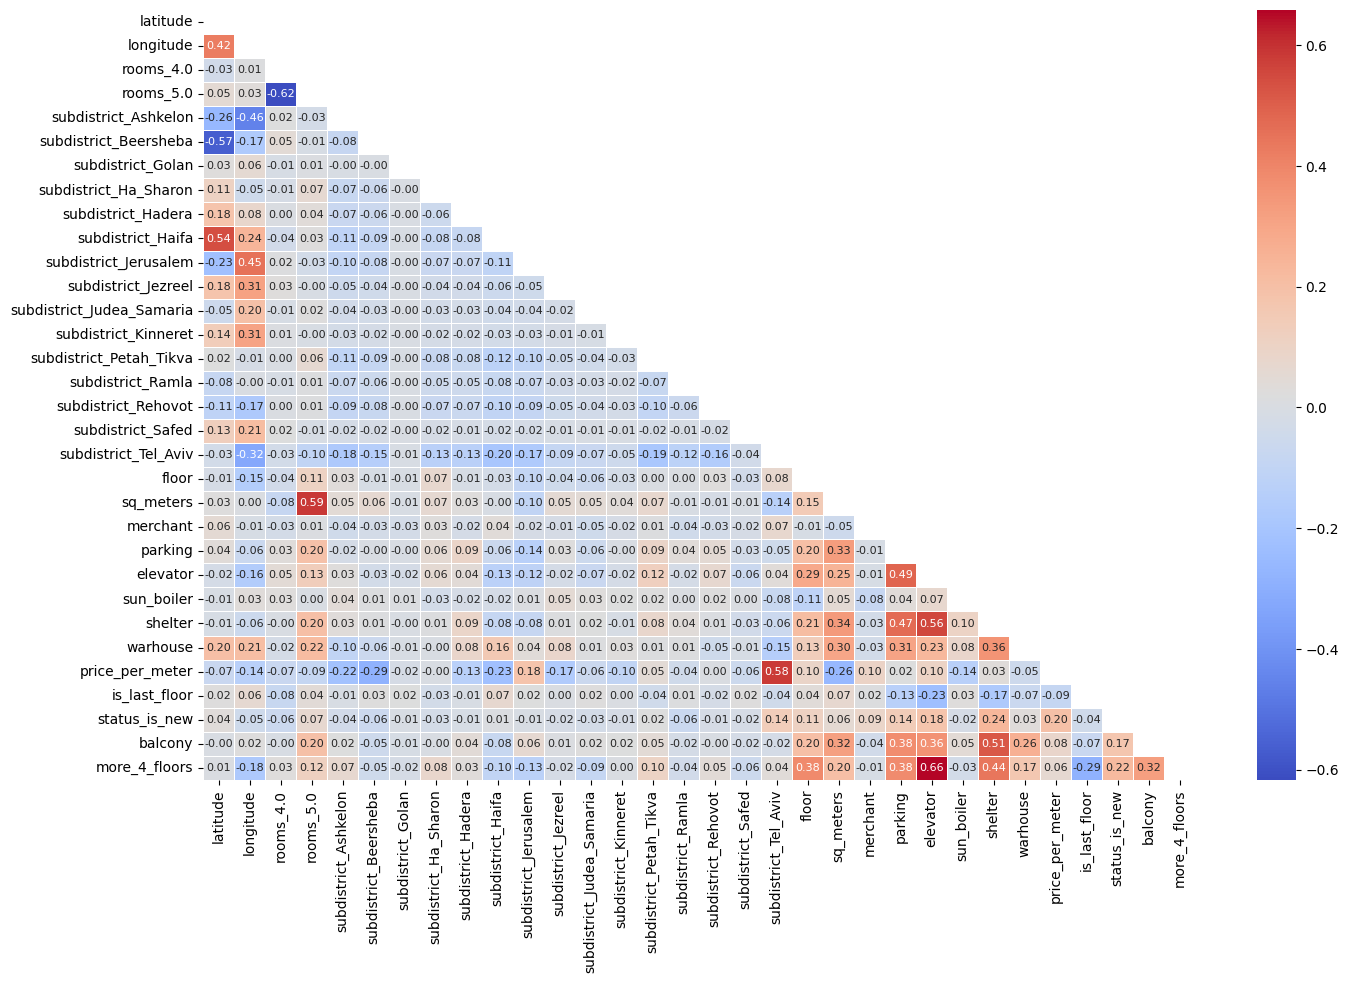

In [39]:
plt.figure(figsize=(16, 10))
sns.heatmap(df_tr.corr(), annot=True, mask=matrix, fmt='.2f',
            linewidths=0.5, linecolor='white',
            annot_kws={"fontsize":8}, cmap='coolwarm') ;

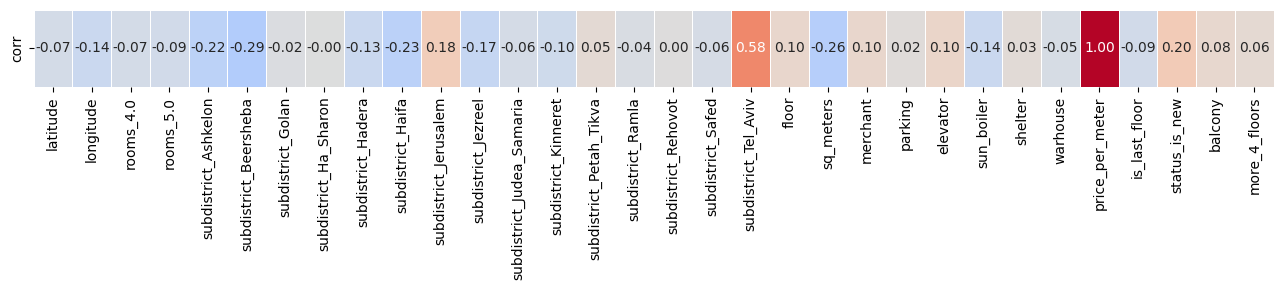

In [66]:
df_corr_price = df_tr.corrwith(df_tr['price_per_meter']).to_frame('corr')

plt.figure(figsize=(16, 1))
sns.heatmap(df_corr_price.T, annot=True, fmt='.2f', center=0,
            linewidths=0.5, linecolor='white', cbar=False,
            annot_kws={"fontsize":10}, cmap='coolwarm') ;

## Split the Data

**Split the data into features (X) and target variable (y)**

In [ ]:
#define response variable
y = df_tr['price_per_meter']

#define predictor variables
X = df_tr.drop(['price_per_meter'], axis=1)

**Split the data into training and testing sets (e.g., 67% training, 33% testing)**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.33,
                                                    random_state = 777)

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test:  {X_test.shape},  y_test:   {y_test.shape}')

X_train: (17983, 31), y_train: (17983,)
X_test:  (8858, 31),  y_test:   (8858,)


## Linear Regression (BaseModel)

**Define the LinearRegression model, fit and get coefficients**

In [ ]:
lr = LinearRegression().fit(X_train, y_train)

df_lr_coef = pd.DataFrame(lr.coef_, index=X_train.columns, columns=['coef']
                          ).sort_values(by='coef', ascending=False)

In [ ]:
lr.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

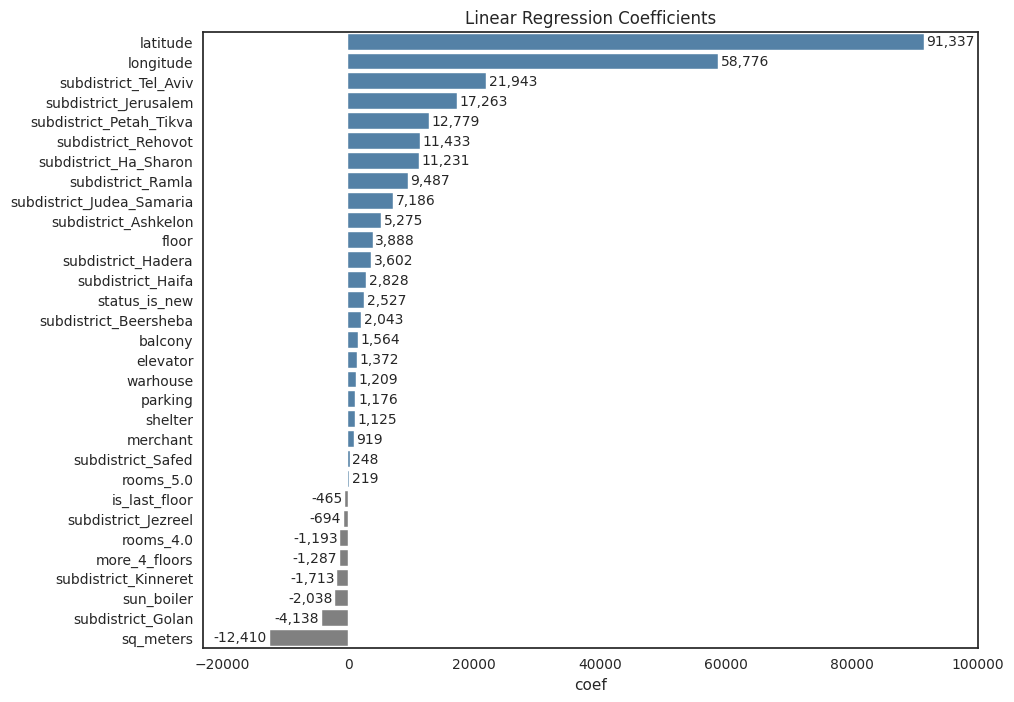

In [ ]:
plt.figure(figsize=(10, 8))

cols = ['grey' if x <= 0 else 'steelblue' for x in df_lr_coef.values]
ax = sns.barplot(y=df_lr_coef.index,
                 x=df_lr_coef.coef, data=df_lr_coef,
                 palette=cols)
for i in range(len(ax.containers)):
  ax.bar_label(ax.containers[i], fmt=(lambda x: f'{x:,.0f}'), padding=2, fontsize=10)
ax.set_xlim(-23_000, 100_000)
ax.set(title='Linear Regression Coefficients')
ax.set(ylabel='');

In [ ]:
predict_score(X_train, X_test, y_train, y_test, lr)

R2_train = 0.611 	RMSE_train = 6,821
R2_test =  0.606   	RMSE_test =  7,053 


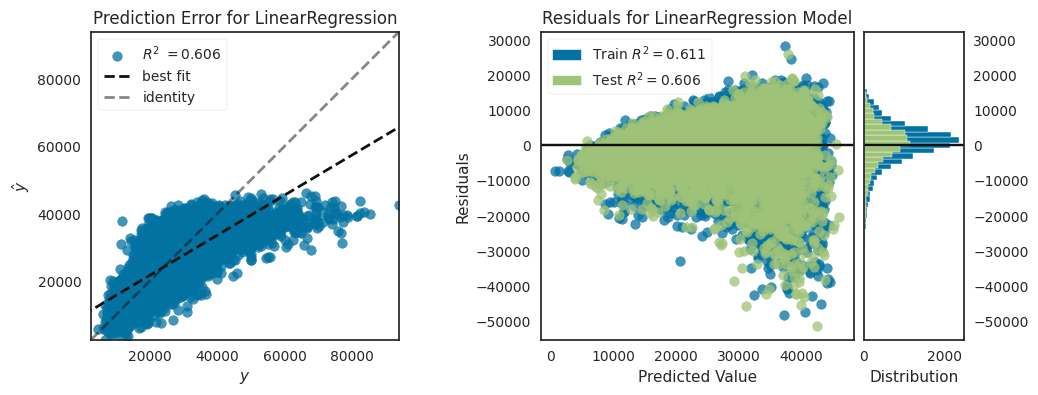

In [ ]:
predict_error_residual_plot(lr, X_train, y_train, X_test, y_test)

**Select features**

In [ ]:
lr_rmse = {}
for n in range(2, 31+1):
    rfe = RFE(estimator=LinearRegression(),
              n_features_to_select=n)
    pipe_lr = Pipeline(steps = [
                        ('rfe', rfe),
                        ('model', lr)])

    pipe_lr.fit(X_train, y_train)
    y_hat_test = pipe_lr.predict(X_test)
    lr_rmse[n] = mse(y_test, y_hat_test, squared=False)
print('ok')

ok


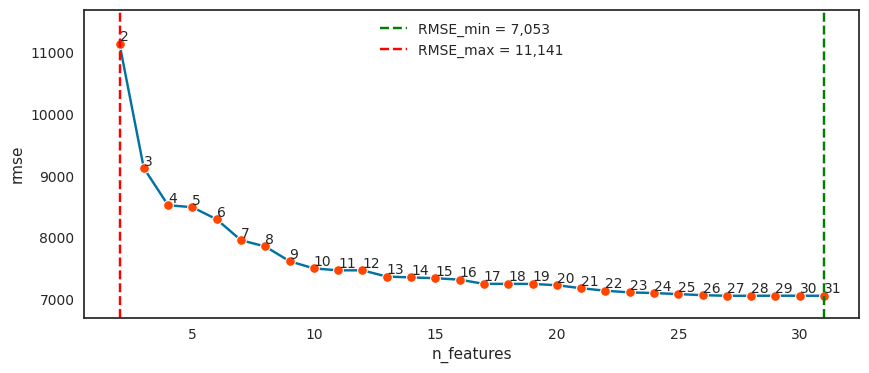

In [ ]:
lineplot_rmse(lr_rmse)

### ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV

# Define the model
model = ElasticNet()

# Hyperparameters:
'''Alpha (α): Controls the overall strength of the regularization.
   L1 Ratio (λ): Balances between L1 (Lasso) and L2 (Ridge) regularization.'''
# Define the parameter grid
param_grid = {
    'alpha': np.arange(0.1, 1.1, 0.1),
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Implement RandomizedSearch with Cross-Validation
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_grid,
                                   n_iter=20, cv=3)
random_search.fit(X_train, y_train)

# Best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {random_search.best_score_:.3f}")

Best Parameters: {'l1_ratio': 0.9, 'alpha': 0.1}
Best Score: 0.595


In [ ]:
predict_score(X_train, X_test, y_train, y_test, best_model)

R2_train = 0.596 	RMSE_train = 6,950
R2_test =  0.588   	RMSE_test =  7,217 


In [ ]:
pd.DataFrame(random_search.cv_results_['params']
             ).join(pd.DataFrame(random_search.cv_results_['mean_test_score'],
                                 columns=['mean_test_score'])).T.style.format('{:,.2f}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
l1_ratio,0.70,0.30,0.10,0.70,0.30,0.90,0.10,0.10,0.90,0.90,0.90,0.90,0.10,0.30,0.50,0.30,0.30,0.50,0.70,0.90
alpha,0.40,0.70,0.10,0.60,0.10,0.60,0.70,0.20,0.30,0.80,0.20,1.00,0.80,0.80,0.50,1.00,0.40,0.10,0.30,0.10
mean_test_score,0.46,0.25,0.49,0.40,0.51,0.53,0.21,0.40,0.57,0.50,0.58,0.48,0.19,0.23,0.35,0.20,0.34,0.54,0.49,0.59


## DecisionTreeRegressor

In [ ]:
# define hyperparameter for grid search
param_grid = {
    'max_depth': [7, 9, 11],
    'min_samples_leaf': [30, 50, 70],
}
tree = DecisionTreeRegressor(random_state=555)

# get best hyperparameters
scor ='neg_mean_absolute_error'
grid_search = GridSearchCV(tree, param_grid=param_grid,
                           cv=5, scoring=scor)
grid_search.fit(X_train, y_train)
print(f'best_score: {scor} = {-grid_search.best_score_:,.0f}')
print(f'best_params = {grid_search.best_params_}')

best_score: neg_mean_absolute_error = 3,092
best_params = {'max_depth': 11, 'min_samples_leaf': 30}


In [ ]:
pd.DataFrame(grid_search.cv_results_['params']
             ).join(pd.DataFrame(grid_search.cv_results_['mean_test_score'],
                                 columns=['mean_test_score'])).T.style.format('{:,.0f}')

,0,1,2,3,4,5,6,7,8
max_depth,7,7,7,9,9,9,11,11,11
min_samples_leaf,30,50,70,30,50,70,30,50,70
mean_test_score,"-3,547","-3,579","-3,607","-3,229","-3,295","-3,347","-3,092","-3,174","-3,234"


In [ ]:
tree_best = grid_search.best_estimator_
predict_score(X_train, X_test, y_train, y_test, tree_best)

R2_train = 0.866 	RMSE_train = 4,008
R2_test =  0.840   	RMSE_test =  4,494 


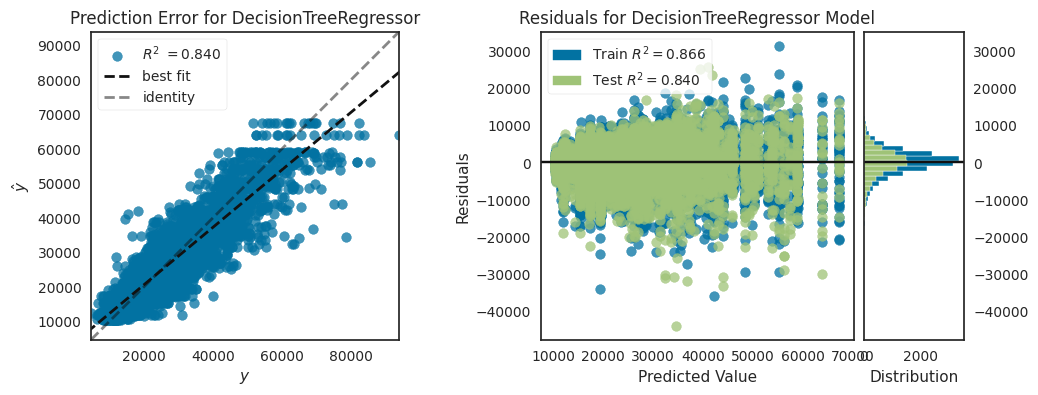

In [ ]:
predict_error_residual_plot(tree_best, X_train, y_train, X_test, y_test)

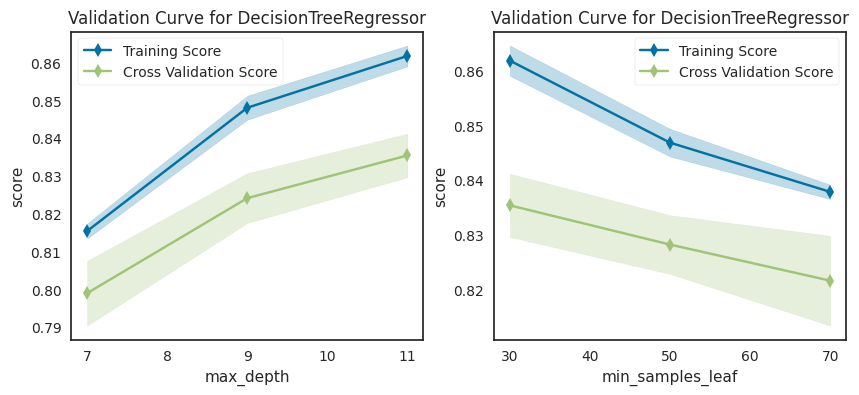

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for i, (k, v) in enumerate(param_grid.items()):
    viz = validation_curve(
        tree_best, X_train, y_train, param_name=k, ax=axs[i], show=False,
        param_range=v, cv=5, scoring="r2", n_jobs=-1)

In [ ]:
def visualize_tree(model, md=7, fs=(16, 6)):
    plt.figure(figsize=fs)
    plot_tree(model,
              max_depth=md,
              feature_names=model.feature_names_in_,
              label='all',
              filled=True,
              rounded=True,
              fontsize=7);

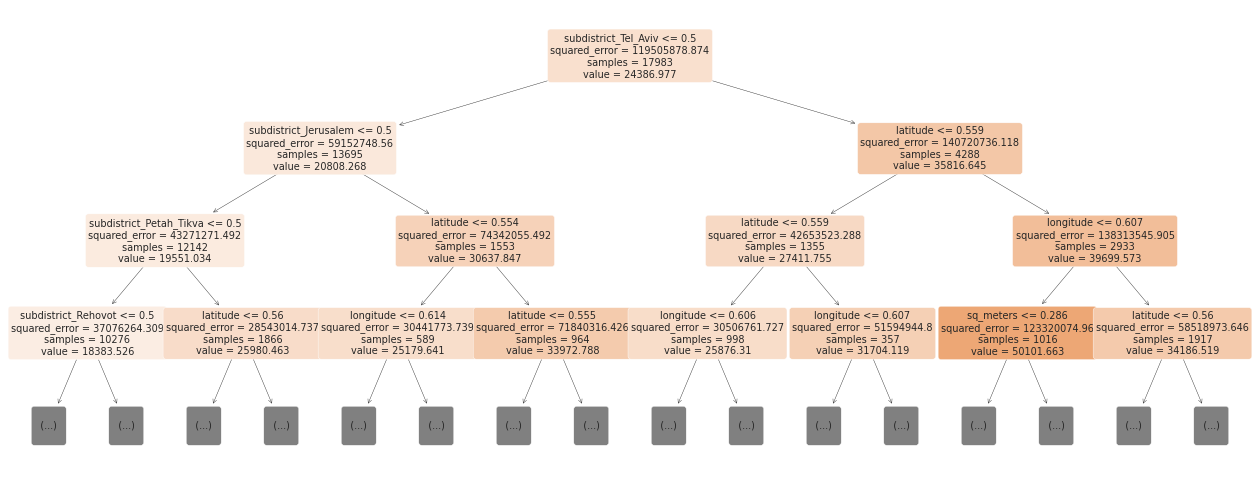

In [ ]:
visualize_tree(tree_best, md=3)

### Feature importances

In [ ]:
df_tree_coef = pd.DataFrame(data= tree_best.feature_importances_,
                           index=tree_best.feature_names_in_,
                           columns=['coef']).sort_values(by='coef', ascending=False)[:10]

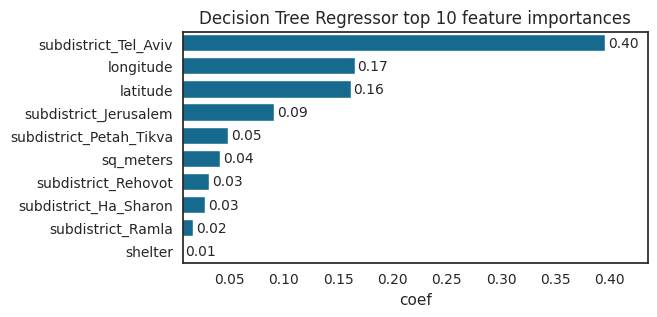

In [ ]:
feature_importances_plot(df_tree_coef, 'Decision Tree Regressor')

In [ ]:
tree_rmse = {}
for n in range(2, 31+1):
    rfe = RFE(estimator=DecisionTreeRegressor(random_state=333),
              n_features_to_select=n)
    pipe_tree = Pipeline(steps = [
                        ('rfe', rfe),
                        ('model', tree_best)])

    pipe_tree.fit(X_train, y_train)
    y_hat_test = pipe_tree.predict(X_test)
    tree_rmse[n] = mse(y_test, y_hat_test, squared=False)
print('ok')

ok


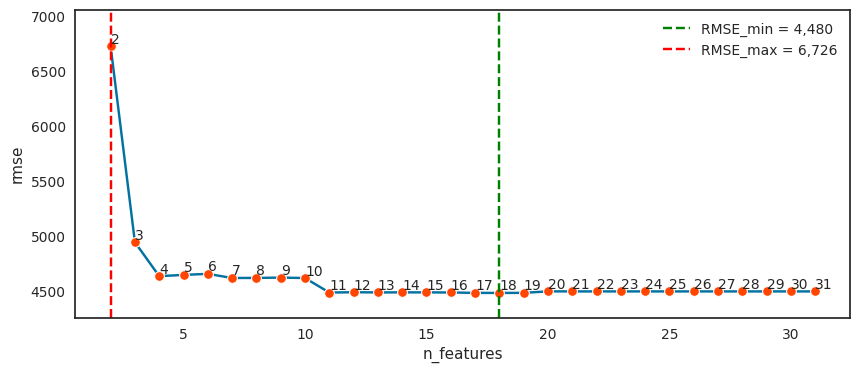

In [ ]:
lineplot_rmse(tree_rmse)

### Select 'n' features for best score

In [ ]:
model_n = select_n_features(18, tree_best, X_train, y_train)
model_n[0].get_feature_names_out().tolist()

['latitude',
 'longitude',
 'subdistrict_Ha_Sharon',
 'subdistrict_Jerusalem',
 'subdistrict_Petah_Tikva',
 'subdistrict_Ramla',
 'subdistrict_Rehovot',
 'subdistrict_Tel_Aviv',
 'floor',
 'sq_meters',
 'parking',
 'elevator',
 'sun_boiler',
 'shelter',
 'warhouse',
 'is_last_floor',
 'status_is_new',
 'balcony']

In [ ]:
predict_score(X_train, X_test, y_train, y_test, model_n)

R2_train = 0.865 	RMSE_train = 4,010
R2_test =  0.841   	RMSE_test =  4,480 


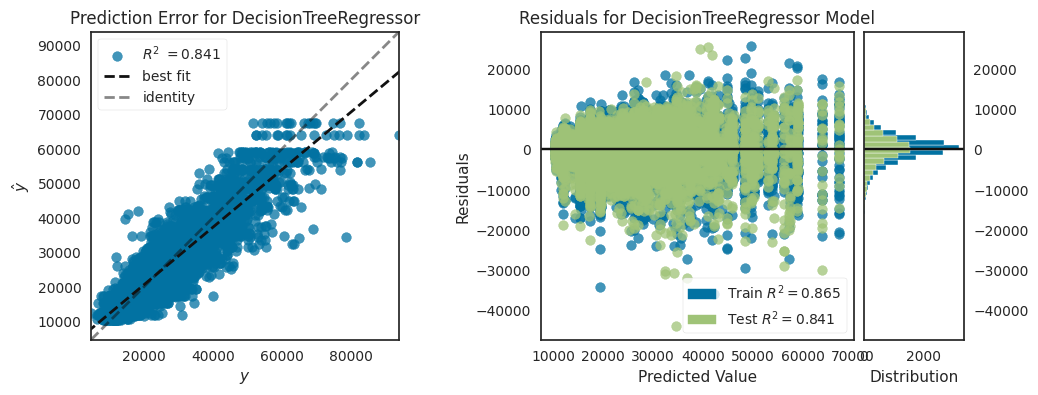

In [ ]:
predict_error_residual_plot(model_n, X_train, y_train, X_test, y_test)

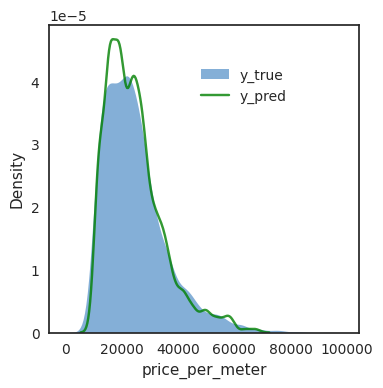

In [ ]:
#create density plot for y_pred vs y_test
density_plot_prediction(model_n, y_test)

In [ ]:
#get feature ranking
pd.DataFrame(data=model_n[0].ranking_, columns=['rank'],
             index=X_train.columns).sort_values(by='rank')
             #)[model_n[0].support_]

## RandomForestRegressor

In [ ]:
rfr_0 = RandomForestRegressor(random_state=700).fit(X_train, y_train)

In [ ]:
predict_score(X_train, X_test, y_train, y_test, rfr_0)

R2_train = 0.985 	RMSE_train = 1,349
R2_test =  0.889   	RMSE_test =  3,750 


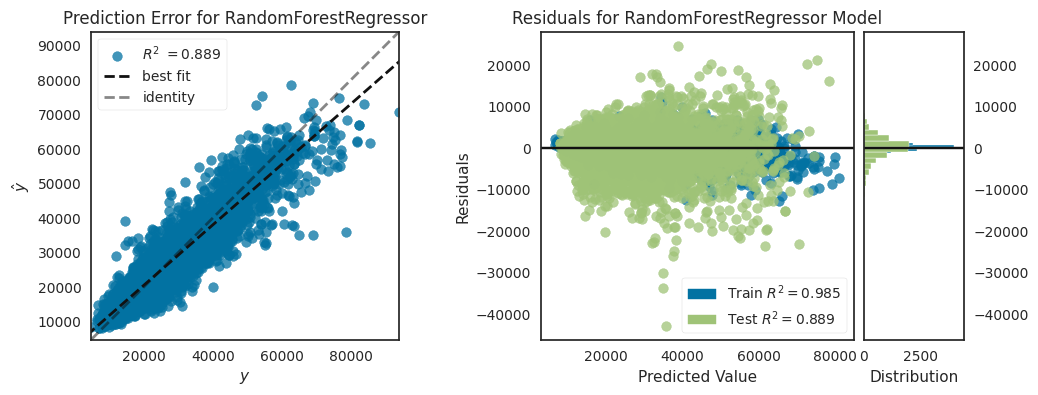

In [ ]:
predict_error_residual_plot(rfr_0, X_train, y_train, X_test, y_test)

**GridSearchCV**

In [ ]:
param_rfr = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [30, 50, 100]}

rfr = RandomForestRegressor(random_state=777)
# get best hyperparameters
scor ='r2'
grid_search = GridSearchCV(rfr , param_grid=param_rfr,
                           cv=3, scoring=scor)
grid_search.fit(X_train, y_train)
print(f'best_score: {scor} = {grid_search.best_score_:.3f}')
print(f'best_params = {grid_search.best_params_}')

best_score: r2 = 0.825
best_params = {'max_depth': 7, 'min_samples_leaf': 30, 'n_estimators': 200}


In [ ]:
rfr_best = grid_search.best_estimator_
predict_score(X_train, X_test, y_train, y_test, rfr_best)

R2_train = 0.840 	RMSE_train = 4,376
R2_test =  0.827   	RMSE_test =  4,673 


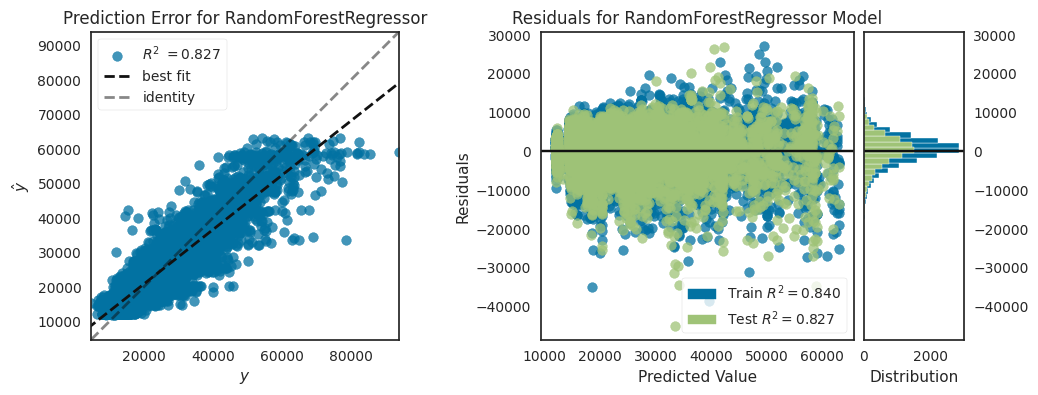

In [ ]:
predict_error_residual_plot(rfr_best, X_train, y_train, X_test, y_test)

In [ ]:
df_rfr_coef = pd.DataFrame(rfr_best.feature_importances_,
                           index=X_train.columns,
                           columns=['coef']
                           ).sort_values(by='coef', ascending=False)[:10]

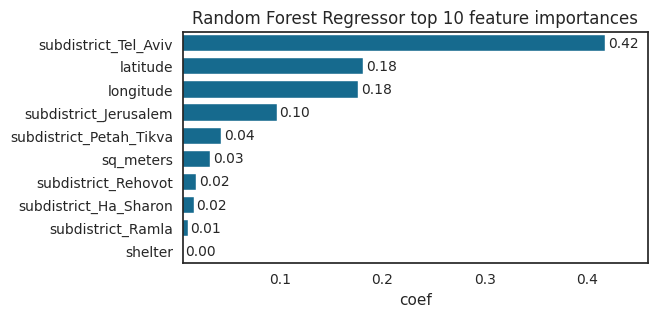

In [ ]:
feature_importances_plot(df_rfr_coef, 'Random Forest Regressor')

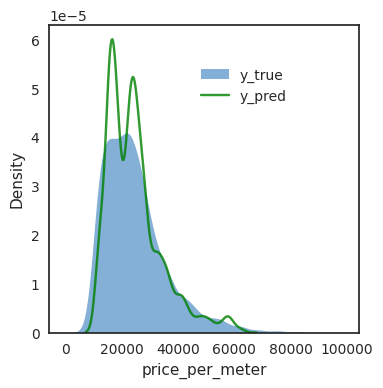

In [ ]:
#create density plot for y_pred vs y_test
density_plot_prediction(rfr_best, y_test,)

##KNeighborsRegressor

In [ ]:
# Initialize model
knn = KNeighborsRegressor()

# Define the parameter grid
knn_grid = {'n_neighbors': [5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]}

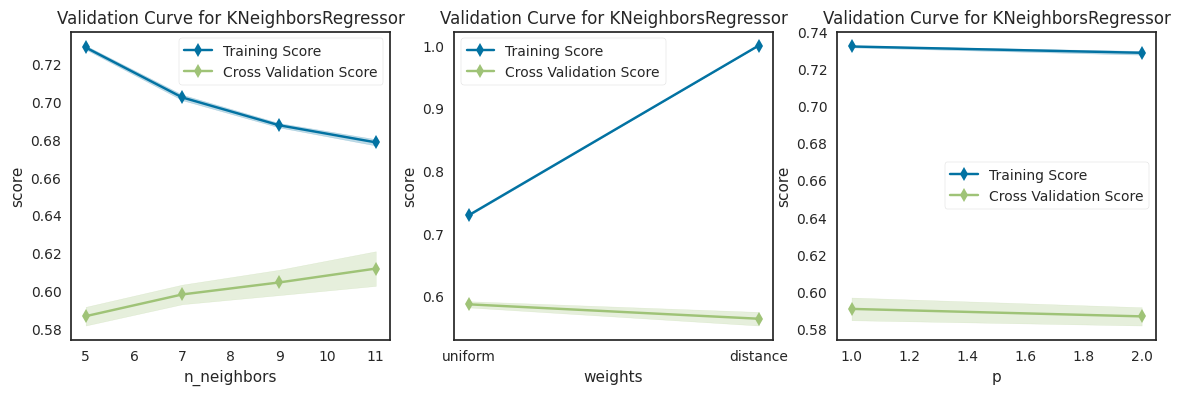

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
for i, (k, v) in enumerate(knn_grid.items()):
    viz = validation_curve(
        knn, X_train, y_train, param_name=k, ax=axs[i], show=False,
        param_range=v, cv=5, scoring="r2", n_jobs=-1)

In [ ]:
# get the best hyperparameters and estimator
scor ='r2'
grid_search = GridSearchCV(knn, param_grid=knn_grid,
                           cv=5, scoring=scor)
grid_search.fit(X_train, y_train)
print(f'best_score: {scor} = {grid_search.best_score_:.3f}')
print(f'best_params = {grid_search.best_params_}')

best_score: r2 = 0.614
best_params = {'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}


In [ ]:
knn_best = grid_search.best_estimator_
predict_score(X_train, X_test, y_train, y_test, knn_best)

R2_train = 0.684 	RMSE_train = 6,149
R2_test =  0.625   	RMSE_test =  6,881 


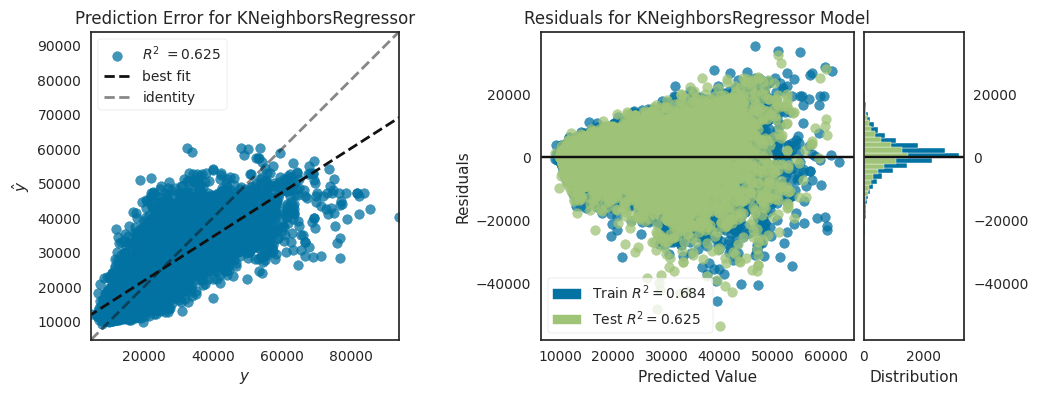

In [ ]:
predict_error_residual_plot(knn_best, X_train, y_train, X_test, y_test)

### Select features with RFE

In [ ]:
knn_best.n_features_in_

31

In [ ]:
dict_rmse = {}
for n in range(2, 31+1):
    rfe = RFE(estimator=DecisionTreeRegressor(random_state=333),
              n_features_to_select=n)
    pipe_knn = Pipeline(steps = [
                        ('rfe', rfe),
                        ('model', knn_best)])

    pipe_knn.fit(X_train, y_train)
    y_hat_test = pipe_knn.predict(X_test)
    dict_rmse[n] = mse(y_test, y_hat_test, squared=False)
print('ok')

ok


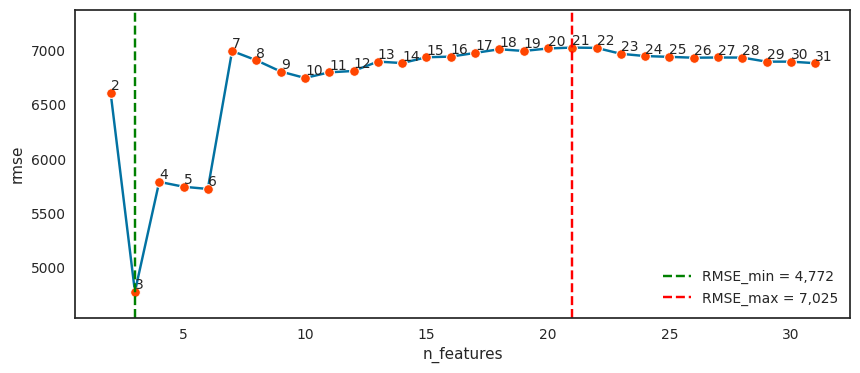

In [ ]:
lineplot_rmse(dict_rmse)

**Select 3 features for best score**

In [ ]:
knn_n = select_n_features(3, knn_best, X_train, y_train)
knn_n[0].get_feature_names_out().tolist()

['latitude', 'longitude', 'subdistrict_Tel_Aviv']

In [ ]:
predict_score(X_train, X_test, y_train, y_test, knn_n)

R2_train = 0.850 	RMSE_train = 4,233
R2_test =  0.820   	RMSE_test =  4,772 


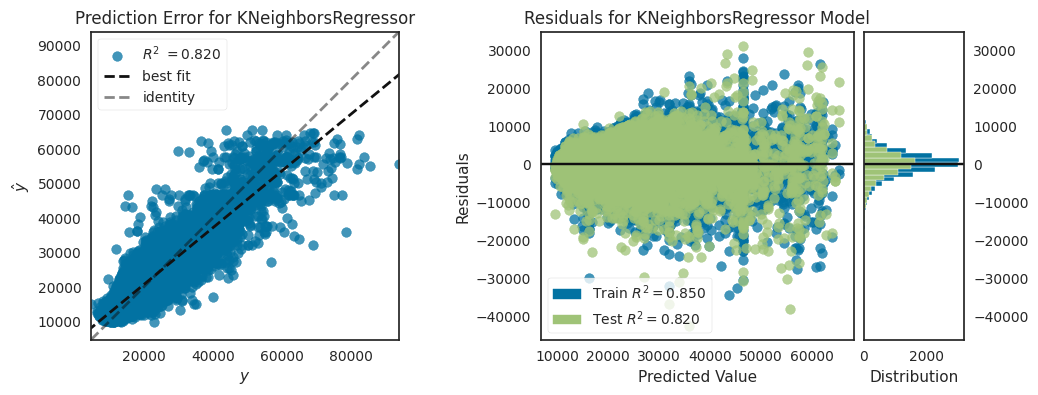

In [ ]:
predict_error_residual_plot(knn_n, X_train, y_train, X_test, y_test)

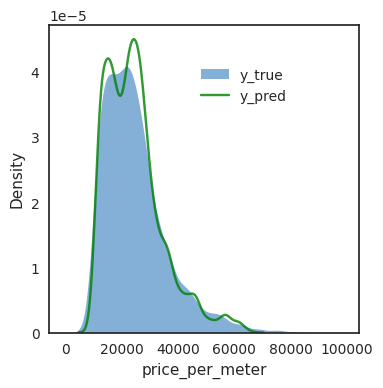

In [ ]:
#create density plot for y_pred vs y_test
density_plot_prediction(knn_n, y_test,)

In [ ]:
#get feature ranking
pd.DataFrame(data=knn_n[0].ranking_, columns=['rank'],
             index=X_train.columns).sort_values(by='rank')[:7]

,rank
latitude,1
longitude,1
subdistrict_Tel_Aviv,1
sq_meters,2
subdistrict_Jerusalem,3
subdistrict_Petah_Tikva,4
floor,5
